<a href="https://colab.research.google.com/github/simonka0808/AdaptiveSolutionsCorrectCode/blob/main/2022_CM4107_CW_1_Template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Submission Information
---

How to get the link to submit the notebook ?
*   Click the Share button (Top right corner)
*   In Get Link section, click change and choose **anyone with link**
* Make sure the access shows **"Editor"**
* Click on **Copy link**

Find below screenshot for reference.

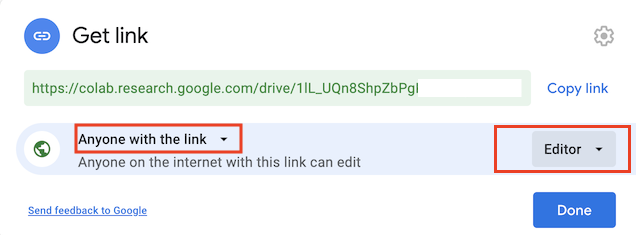

Please complete the below section

In [205]:
# Student Name = ENTER YOUR NAME HERE
# Student ID = ENTER YOUR ID HERE
# Student Email = ENTER YOUR EMAIL HERE

# Helper functions and imports

In [206]:
# Import required libraries
import pandas as pd
import numpy as np
import scipy.special

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")

import os
# helper to load data from PNG image files# helpe 
import imageio
# glob helps select multiple files using patterns
import glob
# helps to manipulate the image for rotation 


In [207]:
from __future__ import division # backward compatibility for python2
import operator
import random


np.random.seed(42)

## Import dataset

In [208]:
# file paths to MNIST on Colab
train_file = "sample_data/mnist_train_small.csv"
test_file = "sample_data/mnist_test.csv"

## Data Preprocessing

In [209]:
df_orig_train = pd.read_csv(train_file, header=None)  # read entire train dataset
df_orig_test = pd.read_csv(test_file, header=None)  # read entire test dataset
df_orig_train.info()

#all of the train data
y_train_all =  pd.get_dummies(df_orig_train[0]).values # Dataframes converted to ndarrays here
X_train_all = df_orig_train.drop(0, axis = 1).values
print(y_train_all.shape)
print(X_train_all.shape)
#all of the test data
y_test_all =  pd.get_dummies(df_orig_test[0]).values
X_test_all = df_orig_test.drop(0, axis = 1).values
print(y_test_all.shape)
print(X_test_all.shape)

# Select smaller samples of the train and test datasets (will execute faster when training our networks than using the entire dataset)
train_sample_size = 20000 # choosing a smaller sample instead of the entire dataset
random_indices = np.random.choice(range(len(y_train_all)), train_sample_size, replace = False)
X_train = X_train_all[random_indices]
y_train = y_train_all[random_indices]
print(y_train.shape)
print(X_train.shape)
#preprocessing normalise training data
X_train = (X_train / 255.0 * 0.99) + 0.01
y_train = y_train + 0.01
y_train = np.where(y_train != 1.01, y_train, 0.99)
print(y_train.shape)

# get a smaller test sample 
test_sample_size = 10000
random_test_indices = np.random.choice(range(len(y_test_all)), test_sample_size, replace = False)
X_test = X_test_all[random_test_indices]
y_test = y_test_all[random_test_indices]
print(y_test.shape)
print(X_test.shape)
#preprocessing normalise test data
X_test = (X_test / 255.0 * 0.99) + 0.01
y_test = y_test + 0.01
y_test = np.where(y_test != 1.01, y_test, 0.99)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Columns: 785 entries, 0 to 784
dtypes: int64(785)
memory usage: 119.8 MB
(20000, 10)
(20000, 784)
(10000, 10)
(10000, 784)
(20000, 10)
(20000, 784)
(20000, 10)
(10000, 10)
(10000, 784)


In [210]:
def mean_squared_error(predictions, targets):
    """
    Calculates mean squared error of a model's predictions.
    """
    N=targets.size
    mse = ((targets - predictions) **2).sum() / (2*N)
    return mse


def accuracy(predictions, targets):
    """
    Calculates the accuracy of a model's predictions.
    """
    prediction_labels = np.argmax(predictions, axis=1)
    target_labels = np.argmax(targets, axis=1)
    predictions_correct = (prediction_labels == target_labels.round())
    accuracy = predictions_correct.mean()
    return accuracy

# TASK 1 - Activation functions for ANN
---

In labs you explored Sigmoid and ReLU.

In [211]:
class Activation_ReLU:
    def forward(self, x):
        return(np.maximum(0, x))
    def backward(self, x):
       return(np.greater_equal(x, 0).astype(int)) # inputs > 0 then convert bools to int
        
class Activation_Sigmoid:
    def forward(self, x):
        return(1 / (1 + np.exp(-x)))
    def backward(self, x):
        return(x * ( 1 - x))

## 1.1 (a) Implement LeakyReLU activation function

In [212]:
class Activation_LeakyReLU:
    def forward(self, inputs, alpha = 0.0001):
        # TODO: 
       return np.maximum(alpha*inputs,inputs)

    def backward(self, inputs, alpha = 0.0001):
        # TODO:  # inputs > ALPHA then convert bools to int
         # inputs > 0 then convert bools to int
        return(np.greater_equal(inputs, alpha).astype(int))

## 1.1 (b) Implement Linear activation function

In [213]:
class Activation_Linear:
    def forward(self, inputs, m=1, c=0):
       # TODO: # linear equation where m and c can be set
       return m*inputs + c


    def backward(self, inputs, m=1, c=0):
       # TODO:
       return m

In [214]:
class Layer_Dense:
    def __init__(self, n_inputs, n_neurons):
        # weights initialised from a gaussian with mean 0 and variance 1
        # multiply with a small value just to ensure we start with small weight values
        self.weights = 0.1*  np.random.normal(0.0, pow(n_inputs, -0.5), (n_inputs, n_neurons))
        self.biases = np.zeros((1, n_neurons))
       
    def forward(self, inputs, act):
        self.inputs = inputs #need this when backpropagating so maintain it in the layer class
        z = np.dot(inputs , self.weights) + self.biases # weights dot product
        self.outputs = act.forward(z) # nonlinear activation output of the layer
            
    def backward(self, error, act):
        delta = error * act.backward(self.outputs)
        self.dinputs = np.dot(delta, self.weights.T)  #this layer's error 
        
        N = self.dinputs.shape[0]
        self.dweights = np.dot(self.inputs.T, delta) / N  # derivatives for weights used by the optimizer class  
        self.dbiases = np.mean(delta, axis=0, keepdims=True) # derivatives for biases used by the optimizer class 
    
    
class Optimizer_SGD:
    def __init__(self, learningrate=0.3):
           self.lr = learningrate
            
    def weight_update(self, layer):       
        layer.weights -= self.lr * layer.dweights
        layer.biases -= self.lr * layer.dbiases

In [215]:
class ANN():
    def __init__(self, ouput_layer, act2, hidden_layer, act1, opt, batch_size = 10):
        self.layer2 = ouput_layer
        self.act2 = act2
        self.layer1 = hidden_layer
        self.act1 = act1
        self.opt = opt
        self.batch_size = batch_size

    def batch_input(self, x, y):
        for i in range(0, len(x), self.batch_size):
            yield (x[i:i + self.batch_size], y[i:i + self.batch_size])

    def train(self, x, y, epochs, opt, lr=0.3):
        opt.lr = lr

        monitoring = {}
        monitoring['mean_squared_error'] = []
        monitoring['accuracy'] = []

        for epoch in range(epochs):

            for (batch_x, batch_y) in self.batch_input(x, y):
                self.layer1.forward(batch_x, self.act1)
                self.layer2.forward(self.layer1.outputs, self.act2)

                #calculate the loss
                loss=(self.layer2.outputs-batch_y)
                
                # backprop through the layers 
                self.layer2.backward(loss, self.act2)
                self.layer1.backward(self.layer2.dinputs, self.act1)

                # update all the layer weights
                self.opt.weight_update(self.layer1)
                self.opt.weight_update(self.layer2)
               

            pred = self.predict(x)
            mse, acc = self.evaluate(pred, y)
            monitoring['mean_squared_error'].append(mse)
            monitoring['accuracy'].append(acc)

        monitoring_df = pd.DataFrame(monitoring)   
        return monitoring_df

    def predict(self, x):
        self.layer1.forward(x, self.act1)
        self.layer2.forward(self.layer1.outputs, self.act2)
        return self.layer2.outputs


    def embeddings(self, x, layer_type="layer1"):
        # layer_type defaults to output is useful for prediction
        # layer_type=layer1 is useful to get the compressed respresentation from the hidden layer
        
        self.layer1.forward(x, self.act1)
        self.layer2.forward(self.layer1.outputs, self.act2)

        if layer_type == "layer1": 
          return self.layer1.outputs  
        return self.layer2.outputs

    def evaluate(self, predicts, y):
        mse = mean_squared_error(predicts, y)
        acc = accuracy(predicts, y)
        return mse, acc

    def test(self, x, y):
        monitoring = {}
        pred = self.predict(x)
        mse, acc = self.evaluate(pred, y)
        monitoring['mean_squared_error'] = [mse]
        monitoring['accuracy'] = [acc]
        return pd.DataFrame(monitoring)


In [216]:
# Set Other hyperparameters
np.random.seed(42)
batch_size = 20
epochs = 30
lr = 0.3

## 1.2 Complete the experiments





In [217]:
# TODO:
# DO EXPERIMENTS AND EVALUTIONS TO CHOOSE THE BEST ACTIVATION FUNCTIONS FOR A LAYER

#invoke the functions
act1 = Activation_LeakyReLU() #leaky
act2 = Activation_ReLU()
act3 = Activation_Sigmoid()
act4 = Activation_Linear()

sgd = Optimizer_SGD()

#configure the layers
hidden1 = Layer_Dense(784,300) # change to add the new layer  
# hidden2 = Layer_Dense(128,32) # change to add the new layer  
output = Layer_Dense(300,10)


#create the ann models
ann_leaky_relu = ANN(Layer_Dense(20,10), act1, Layer_Dense(784,20), act2, sgd, batch_size)
ann_leaky_sigmoid = ANN(Layer_Dense(20,10), act1, Layer_Dense(784,20), act3, sgd, batch_size)
ann_leaky_linear = ANN(Layer_Dense(20,10), act1, Layer_Dense(784,20), act4, sgd, batch_size)
ann_leaky_only = ANN(Layer_Dense(20,10), act1, Layer_Dense(784,20), act1, sgd, batch_size)



ann_relu_leaky = ANN(Layer_Dense(20,10), act2, Layer_Dense(784,20), act1, sgd, batch_size)
ann_relu_sigmoid = ANN(Layer_Dense(20,10), act2, Layer_Dense(784,20), act3, sgd, batch_size)
ann_relu_linear = ANN(Layer_Dense(20,10), act2, Layer_Dense(784,20), act4, sgd, batch_size)
ann_relu_only = ANN(Layer_Dense(20,10), act2, Layer_Dense(784,20), act2, sgd, batch_size)


ann_sigmoid_relu = ANN(Layer_Dense(20,10), act3, Layer_Dense(784,20), act2, sgd, batch_size)
ann_sigmoid_leaky = ANN(Layer_Dense(20,10), act3, Layer_Dense(784,20), act1, sgd, batch_size)
ann_sigmoid_linear = ANN(Layer_Dense(20,10), act3, Layer_Dense(784,20), act4, sgd, batch_size)
ann_sigmoid_only = ANN(Layer_Dense(20,10), act3, Layer_Dense(784,20), act3, sgd, batch_size)

ann_linear_relu = ANN(Layer_Dense(20,10), act4, Layer_Dense(784,20), act2, sgd, batch_size)
ann_linear_leaky = ANN(Layer_Dense(20,10), act4, Layer_Dense(784,20), act1, sgd, batch_size)
ann_linear_sigmoid = ANN(Layer_Dense(20,10), act4, Layer_Dense(784,20), act3, sgd, batch_size)
ann_linear_only = ANN(Layer_Dense(20,10), act4, Layer_Dense(784,20), act4, sgd, batch_size)



In [218]:

# #train the ann model with the training data
train_performance = ann_leaky_relu.train(X_train, y_train, epochs, sgd, lr)
train_performance




,mean_squared_error,accuracy
0,0.042503,0.32295
1,0.045923,0.22295
2,0.049571,0.16065
3,0.049557,0.16190
4,0.049543,0.16355
5,0.049530,0.16545
6,0.049516,0.16680
7,0.049502,0.16835
8,0.049489,0.16890
9,0.049476,0.17090


In [219]:
train_performance1 = ann_leaky_sigmoid.train(X_train, y_train, epochs, sgd, lr)
train_performance1


,mean_squared_error,accuracy
0,0.04905,0.10115
1,0.04905,0.10115
2,0.04905,0.10115
3,0.04905,0.10115
4,0.04905,0.10115
5,0.04905,0.10115
6,0.04905,0.10115
7,0.04905,0.10115
8,0.04905,0.10115
9,0.04905,0.10115


In [220]:
train_performance2 = ann_leaky_linear.train(X_train, y_train, epochs, sgd, lr)
train_performance2

,mean_squared_error,accuracy
0,0.018648,0.77740
1,0.013368,0.87965
2,0.012939,0.88295
3,0.012863,0.88455
4,0.012825,0.88450
5,0.013134,0.88160
6,0.013055,0.88290
7,0.013047,0.88255
8,0.013024,0.88420
9,0.012952,0.88465


In [221]:
train_performance3 = ann_leaky_only.train(X_train, y_train, epochs, sgd, lr)
train_performance3

,mean_squared_error,accuracy
0,0.008248,0.92240
1,0.007291,0.93320
2,0.006454,0.94335
3,0.006127,0.94595
4,0.005808,0.94835
5,0.005426,0.95310
6,0.005132,0.95625
7,0.004806,0.95900
8,0.004974,0.95780
9,0.004680,0.96015


In [222]:
train_performance4 = ann_relu_sigmoid.train(X_train, y_train, epochs, sgd, lr)
train_performance4

,mean_squared_error,accuracy
0,0.010597,0.90050
1,0.008494,0.92160
2,0.007368,0.93240
3,0.006760,0.93660
4,0.006391,0.94050
5,0.006131,0.94260
6,0.005928,0.94365
7,0.005762,0.94475
8,0.005616,0.94625
9,0.005478,0.94715


In [223]:
train_performance5 = ann_relu_linear.train(X_train, y_train, epochs, sgd, lr)
train_performance5

,mean_squared_error,accuracy
0,0.014633,0.86405
1,0.014017,0.87175
2,0.013732,0.87415
3,0.013555,0.87520
4,0.013436,0.87530
5,0.013344,0.87615
6,0.013268,0.87750
7,0.013206,0.87745
8,0.013156,0.87840
9,0.013114,0.87810


In [224]:
train_performance6 = ann_relu_only.train(X_train, y_train, epochs, sgd, lr)
train_performance6

,mean_squared_error,accuracy
0,0.029900,0.54965
1,0.033466,0.47180
2,0.036449,0.37260
3,0.041653,0.40840
4,NaN,0.09810
5,NaN,0.09810
6,NaN,0.09810
7,NaN,0.09810
8,NaN,0.09810
9,NaN,0.09810


In [225]:
train_performance7 = ann_sigmoid_relu.train(X_train, y_train, epochs, sgd, lr)
train_performance7

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':


,mean_squared_error,accuracy
0,0.013039,0.85690
1,0.012314,0.85665
2,0.011751,0.86105
3,0.011192,0.86800
4,0.010873,0.87045
5,0.010783,0.87105
6,0.010651,0.87135
7,0.010629,0.87155
8,0.010749,0.87125
9,0.010964,0.87175


In [226]:
train_performance16 = ann_sigmoid_leaky.train(X_train, y_train, epochs, sgd, lr)
train_performance16

,mean_squared_error,accuracy
0,0.010974,0.88130
1,0.008173,0.90815
2,0.007192,0.91785
3,0.006571,0.92515
4,0.006064,0.93040
5,0.005758,0.93350
6,0.005487,0.93695
7,0.005259,0.93980
8,0.005059,0.94140
9,0.004864,0.94335


In [227]:
train_performance8 = ann_sigmoid_leaky.train(X_train, y_train, epochs, sgd, lr)
train_performance8

,mean_squared_error,accuracy
0,0.003349,0.96310
1,0.003251,0.96365
2,0.003210,0.96390
3,0.003171,0.96445
4,0.003077,0.96500
5,0.002998,0.96575
6,0.002953,0.96610
7,0.002921,0.96645
8,0.002885,0.96685
9,0.002871,0.96630


In [228]:
train_performance8 = ann_sigmoid_linear.train(X_train, y_train, epochs, sgd, lr)
train_performance8

,mean_squared_error,accuracy
0,0.010916,0.88575
1,0.009079,0.90370
2,0.008346,0.91045
3,0.007940,0.91480
4,0.007688,0.91630
5,0.007513,0.91915
6,0.007385,0.92045
7,0.007289,0.92185
8,0.007214,0.92295
9,0.007154,0.92305


In [229]:
train_performance10 = ann_sigmoid_only.train(X_train, y_train, epochs, sgd, lr)
train_performance10

,mean_squared_error,accuracy
0,0.037454,0.38410
1,0.020764,0.72270
2,0.013459,0.86905
3,0.010315,0.89115
4,0.008892,0.90110
5,0.008077,0.90810
6,0.007531,0.91260
7,0.007129,0.91580
8,0.006817,0.92000
9,0.006564,0.92350


In [230]:
train_performance11 = ann_linear_relu.train(X_train, y_train, epochs, sgd, lr)
train_performance11

,mean_squared_error,accuracy
0,0.022209,0.74170
1,0.026181,0.68680
2,0.034148,0.54795
3,0.039279,0.43800
4,0.069151,0.27550
5,NaN,0.09810
6,NaN,0.09810
7,NaN,0.09810
8,NaN,0.09810
9,NaN,0.09810


In [231]:
train_performance12 = ann_linear_leaky.train(X_train, y_train, epochs, sgd, lr)
train_performance12

,mean_squared_error,accuracy
0,0.012623,0.87560
1,0.010544,0.90710
2,0.009759,0.91930
3,0.009253,0.92600
4,0.009051,0.92695
5,0.008917,0.92915
6,0.008772,0.93085
7,0.008813,0.93000
8,0.008735,0.93205
9,0.008644,0.93305


In [ ]:
train_performance13 = ann_linear_sigmoid.train(X_train, y_train, epochs, sgd, lr)
train_performance13

In [ ]:
train_performance13 = ann_linear_only.train(X_train, y_train, epochs, sgd, lr)
train_performance13

## 1.3 lllustrate your evaluation findings

In [ ]:
# TODO:
# Create graph





In [ ]:
# TODO: ASSIGN THE OPTIMAL ACTIVATION FUNCTION TO THIS GLOBAL VARIABLE
BEST_act1 = ACTIVATION_NAME() #FILL THIS WITH THE OPTIMAL ACTIVATION FUNCTION YOU FOUND OUT
BEST_act2 = ACTIVATION_NAME()

## 1.4 Discuss the results of the experiments (200 words max)

<!-- Your explanation will go here -->
Double-click to type here

---









# TASK 2 - Creating a twin kNN system for the ANN
---



In [ ]:
# HELPER FUNCTIONS

#Within our class we now need code for each of the components of k-NN.
#First, lets create a method that will measure the distance between two vectors.
def euclidean(instance1, instance2):
        '''
        Calculates euclidean distance between two instances of data
        instance1 will be a List of Float values
        instance2 will be a List of Float values
        length will be an Integer denoting the length of the Lists
        '''
        distance = 0
        for val1, val2 in zip(instance1, instance2):            
            distance += pow((val1 - val2), 2)
        
        distance = pow(distance, 1/2)
             
              
        return 1 / (1+ distance)
    

def manhattan(instance1, instance2):
        '''
        Calculates manhattan distance between two instances of data
        instance1 will be a List of Float values
        instance2 will be a List of Float values
        length will be an Integer denoting the length of the Lists
        '''
        distance = 0
        for val1, val2 in zip(instance1, instance2):
            distance += abs(val1 - val2)      
              
        return 1 / (1+ distance)
    
def dot_product(instance1, instance2):
        '''
        Calculates dot product between two instances 
        instance1 will be a List of Float values
        instance2 will be a List of Float values
        length will be an Integer denoting the length of the Lists
        '''
        return np.dot(instance1, instance2)

def accuracy_knn(results):
        '''
        Returns the accuracy of predictions by comparing with the target
        results will be a List of Dictionaries. Each dictionary will contain
          the predicted value and the actual value
        '''
        correct = 0
        for predict, target in results:
            
            if predict == target:
                correct += 1
        return (correct/float(len(results))) * 100.0


def ann_prediction(ann_model, X, y):
    '''
    Returns predictions of an ANN model that are consistent with kNN test function
    '''
    results = [] # store the predictions returned by ANN
    pred = ann_model.predict(X)  # get the predictions
    predict_label_list = np.argmax(pred, axis=1)  # index of max value in list as predicted digit
    predict_label_list= predict_label_list.tolist()  # convert to list
    target_label_list = np.argmax(y, axis=1)  # index of max value in list as target digit
    target_label_list= target_label_list.tolist()  # convert to list
    for predict_label, target_label in zip(predict_label_list, target_label_list):
        results.append([predict_label, target_label])
    return results


## 2.1 Create a method to compute faithfulness between predictions

In [ ]:
def faithfulness(predictions_1, predictions_2):
        '''
        Given two sets of predictions from two different ML algorithms, this will 
        check the rate of agreement between the two sets of predictions. 
        Here predictions_1 will be a List of Lists. Each inner List will contain a
          pair of predicted value and the actual value
        predictions_2 will be a List of Lists. Each inner List will contain a
          pair of predicted value and the actual value
        '''
        match = 0
        # TODO: compare predictions and maintain agreement

        
        return (match/float(len(predictions_1))) * 100.0

In [ ]:
class kNN:
    """
    Parameters
    X_train, Y_train : list
    these consists of the training set feature values and associated class labels
    k : int
    specify the number of neighbours
    sim : literal
    specify the name of the similarity metric (e.g. manhattan, eucliedean)
    weighted : Boolean
    specify the voting strategy as weighted or not weighted by similarity values
  
    Attributes
    -----------  
    Results : list
      Target and predicted class labels for the test data.    
    """


    def __init__(self, X_train, Y_train, k=3, sim=manhattan, weighted=False):
        self.X_train = X_train
        self.Y_train = Y_train
        
        if k <= len(self.X_train):
            self.k = k # set the k value for neighbourhood size
        else:
            self.k = len(self.X_train) # to ensure the get_neighbours dont crash
    
        self.similarity = sim # specify a sim metric that has been pre-defined e.g. manhattan or euclidean
        
        self.weighted = weighted # boolean to choose between weighted / unweighted majority voting
        
        #store results from testing 
        self.results= []
        
    #With k-NN, we are interested in finding the k number of points with the greatest similarity 
    # to the the query or test instance.
    def get_neighbours(self, test_instance):
        '''
        Locate most similar neighbours 
        X_train will be a containing features (Float) values (i.e. your training data)
        Y_train will be the corresponding class labels for each instance in X_train
        test_instance will be a List of Float values (i.e. a query instance)
        '''
        similarities = [] # collection to store the similarities to be computed

        for train_instance, y in zip(self.X_train, self.Y_train): #for each member of the training set
            sim = self.similarity(test_instance, train_instance) #calculate the similarity to the test instance
            
            similarities.append((y, sim)) #add the actual label of the example and the computed similarity to a collection 
        #print(distances)
        similarities.sort(key = operator.itemgetter(1), reverse = True) #sort the collection by decreasing similarity
        neighbours = [] # holds the k most similar neighbours
        neighbours = [similarities[x] for x in range(self.k)] #extract the k top indices of the collection for return

        return neighbours

    # given the neighbours make a prediction
    # the boolean parameter when set to False will use unweighted majority voting; otherwise weighted majority voting
    # weighting can be helpful to break any ties in voting
    def predict(self, neighbours):
        '''
        Summarise a prediction based upon weighted neighbours calculation
        '''
        class_votes = {}
        for x in range(len(neighbours)):
            response = neighbours[x][0]
            if response in class_votes:
                class_votes[response] += (1-self.weighted) + (self.weighted * neighbours[x][1]) #if not weighted simply add 1
                #class_votes[response] += [1, neighbours[x][1]][weighted == True] 
              
            else:
                class_votes[response] = (1-self.weighted) + (self.weighted * neighbours[x][1])
                #class_votes[response] = [1, neighbours[x][1]][weighted == True] 
                
        #print(class_votes)
        sorted_votes = sorted(class_votes, key = lambda k: (class_votes[k], k), reverse = True)
        #print(sorted_votes)
        return sorted_votes[0]
    
    #iterate through all the test data to calculate accuracy
    def test(self, X_test, Y_test):
        self.results = [] # store the predictions returned by kNN

        for test_instance, target_label in zip(X_test, Y_test):
            neighbours = self.get_neighbours(test_instance)
            predict_label = self.predict(neighbours)
            self.results.append([predict_label, target_label])
            #print('> predicted = ', result,', actual = ', test_label)
    

In [ ]:
# Set hyperparameters
ks = [1, 5, 11, 21, 51]  # try a few different values for k
train_size = 800 # or use the earlier specified "train_sample_size" which may take longer to compute
test_size = 200 # or use the earlier specified "test_sample_size" which may take longer to compute

## 2.2 Create a compressed version of the training and test sets using the ANN layer activations

In [ ]:
# Use the following ANN configuration as your black-box model which needs a twinned kNN explanation
# Configure, Create and use this ANN to get embedings and predictions
batch_size = 20
epochs = 20
sgd = Optimizer_SGD()
lr = 0.3
# configure the layers
hidden_layer = Layer_Dense(784,200)
act1 = Activation_ReLU()
output_layer = Layer_Dense(200,10)
act2 = Activation_Sigmoid()

# create an ANN model
ann = ANN(output_layer, act2, hidden_layer, act1, sgd, batch_size) 
train_performance = ann.train(X_train, y_train, epochs, sgd, lr) # train the model


In [ ]:
#  TODO: layer 1 compression - hint use ann.embeddings and flattened as needed
X_train_compressed_1 = 
X_test_compressed_1 = 


# TODO: layer 2 compression - hint use ann.embeddings and flattened as needed
X_train_compressed_2 = 
X_test_compressed_2 = 


## 2.3 Setup an evaluation to compare to what extent a kNN aligns with the predictions of the ANN with the raw data versus the compressed data

In [ ]:
# CONVERT Y Values to single class not one hot encoding
# because KNN implementation supports only one class
y_train_knn = np.argmax(y_train, axis=1)
y_train_knn= y_train_knn.tolist()

y_test_knn = np.argmax(y_test, axis=1)
y_test_knn= y_test_knn.tolist()


In [ ]:
# faithfulness using raw data (uncompressed)

knn_list = []
knn_exp = {"compression": "No Compression", "faithfulness": []}  # a dictionary to maintain compression type and faithfulness scores
for k in ks: # determine faithfulness for different values of k
  #create the different instances of the kNN class
  knn = kNN(X_train[:train_size], y_train_knn[:train_size], k, euclidean, weighted=True)
  knn.test(X_test[:test_size], y_test_knn[:test_size]) # now get the predictions on the test set
  knn_exp['faithfulness'].append(faithfulness(knn.results, ann_prediction(ann, X_test[:test_size], y_test[:test_size])))

print("kNN Faithfulness to ANN on test set is: ", knn_exp)
knn_list.append(knn_exp)


In [ ]:
# faithfulness using layer 1 compression

knn_exp = {"compression": "Layer 1 Compression", "faithfulness": []}

# TODO:



knn_list.append(knn_exp)

In [ ]:
# faithfulness using layer 2 compression

knn_exp = {"compression": "Layer 2 Compression", "faithfulness": []}

# TODO:



knn_list.append(knn_exp)

## 2.3 Plot a graph that compares the faithfulness of the uncompressed and compressed versions of kNN to ANN and explain findings

In [ ]:
N = len(ks) # this is the number of results we want to plot on the x-axis
ind = np.arange(N) # x axis index
# print(knn_list)

width = 0.25 # width of the bar      
plt.bar(ind, knn_list[0]['faithfulness'], width, label=knn_list[0]['compression'])

# TODO: add layer1 and 2 compressed results to the plot and format the graph




plt.show()

### Explain your findings in no more than 200 words.  

<!-- Your explanation will go here -->
Double-click to type here

---